## Work Notebook for Requirements Engineering Journal Article

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from patsy import dmatrices
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.stats.diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

import research_utils.utils as utils
from research_utils.database.database import Database
from research_utils.analytics.beta_regression import Beta
from research_utils.analytics.lda import TopicModel

In [2]:
database = Database()

In [3]:
data = pd.read_sql(utils.INPUT_QUERY, database.connection)

In [4]:
tm = TopicModel(25, load=True)

In [5]:
df = tm.load_topic_model_results()

In [6]:
df.head()

,issue_time,issue_id,title,body,organization,package,issue_number,all_content,topics
0,2018-05-03 11:33:46,319883485,"Help command line arguments (-h, --help) are i...",The help arguments implicitly defined by the a...,actor-framework,actor-framework,688,"Help command line arguments (-h, --help) are i...","[0.009083141572773457, 0.009083141572773457, 0..."
1,2015-02-24 20:11:09,58796753,Remove match expr,The main objective of this change is to make C...,actor-framework,actor-framework,242,Remove match expr The main objective of this c...,"[0.006975634954869747, 0.006975634954869747, 0..."
2,2014-12-18 16:09:28,52381894,Enable actor publishing at random high-level port,"With this patch, using 0 as port parameter to ...",actor-framework,actor-framework,218,Enable actor publishing at random high-level p...,"[0.008186651393771172, 0.008186651393771172, 0..."
3,2018-01-08 17:03:43,286813990,The udp basp autoconnection test has a leak,"According to asan, there is a leak in the unit...",actor-framework,actor-framework,647,The udp basp autoconnection test has a leak Ac...,"[0.010533114895224571, 0.3219645917415619, 0.0..."
4,2014-12-17 11:32:12,52229707,Topic/pullrequest,More tests for the jenkins PR builder.\n,actor-framework,actor-framework,216,Topic/pullrequest More tests for the jenkins P...,"[0.013114626519382, 0.013114626519382, 0.01311..."


In [7]:
for i in range(tm.num_topics):
    df['topic_{}'.format(i)] = [x[i] if x else np.nan for x in df['topics']]
    df['topic_{}_2'.format(i)] = df['topic_{}'.format(i)]**2

In [8]:
all_topics = []
reg_topics = []
simple_reg_topics = []
simple_reg_topics_2 = []
for i in range(tm.num_topics-1):    
    all_topics.append('topic_{}'.format(i))
    simple_reg_topics.append('topic_{}'.format(i))
    all_topics.append('topic_{}_2'.format(i))
    simple_reg_topics_2.append('topic_{}_2'.format(i))
    for j in range(tm.num_topics-1):
        reg_topics.append("topic_{}*topic_{}".format(i, j))
        #reg_topics.append("topic_{}_2".format(i, j))

In [9]:
mean_topics = df.groupby(['organization', 'package']).mean()[all_topics]

In [10]:
all_data = mean_topics.merge(data, on=['package', 'organization'])

In [11]:
all_data['crowd_pct_sq'] = np.sqrt(all_data['crowd_pct'])
all_data['crowd_pct_2'] = all_data['crowd_pct']**2
all_data['issues_over_time'] = (all_data['total_issues'] / all_data['project_age'])*90
all_data['avg_clusteringXcrowd_pct'] = all_data['avg_clustering'] * all_data['crowd_pct']
all_data['avg_min_pathXcrowd_pct'] = all_data['avg_min_path'] * all_data['crowd_pct']
all_data['gini_coefficientXcrowd_pct'] = all_data['gini_coefficient'] * all_data['crowd_pct']
all_data['log_duration'] = np.log(all_data['duration_median'] + 1e-7)
all_data['log_duration_mean'] = np.log(all_data['duration_mean'] + 1e-7)
all_data['pct_under_30'] = all_data['under_30'] / all_data['total_issues']
all_data['pct_under_60'] = all_data['under_60'] / all_data['total_issues']
all_data['pct_under_90'] = all_data['under_90'] / all_data['total_issues']
all_data.to_csv('/home/matt/research_data.csv', index=False)

In [12]:
base_columns = ['crowd_pct', 'crowd_pct_2',
                'avg_clustering', 'avg_min_path', 'gini_coefficient',
                'avg_clusteringXcrowd_pct', 'avg_min_pathXcrowd_pct', 'gini_coefficientXcrowd_pct',
                'total_contributors', 'project_age']
base_features = ' + '.join(base_columns)

In [13]:
def glm_marginal_effect(variable, res, X, all_data):
    """Computes the GLM marginal effects for the variable.
    
    Parameters
    ----------
    variable : str
        the variable for which we would like to calculate the marginal effect
    res : sm.model
        results of the linear regression
    X : pd.DataFrame
        the input to the linear regression
    all_data : pd.DataFrame
        the full set of input data
        
    Returns
    -------
    marginal_effect : float
    """
    data = all_data.copy(deep=True)
    param = res.params[variable]
    cross_term = '{}Xcrowd_pct'.format(variable)
    if cross_term in res.params:
        data['effect'] = param + data['crowd_pct'] * res.params[cross_term]
    else:
        data['effect'] = param
    data['prediction'] = res.predict(X)
    data['marginal_effect'] = data['effect'] * data['prediction']
    return data['marginal_effect'].mean()

### Exploratory Data Analysis

Text(0, 0.5, 'Crowd Pct')

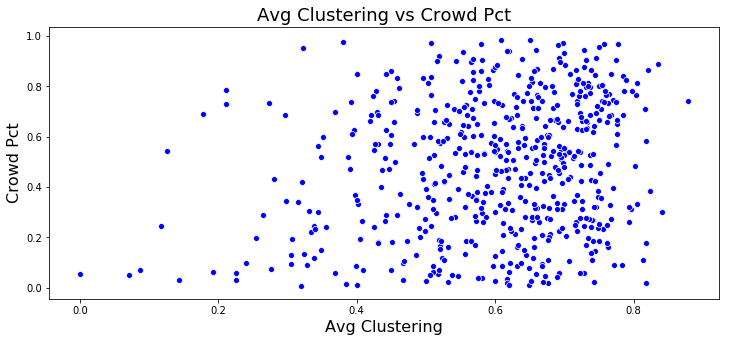

In [14]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=all_data['avg_clustering'], y=all_data['crowd_pct'], color='blue')
plt.title('Avg Clustering vs Crowd Pct', fontsize=18)
plt.xlabel('Avg Clustering', fontsize=16)
plt.ylabel('Crowd Pct', fontsize=16)
#plt.ylim([0, 1])
#plt.xlim([0, 1])

Text(0, 0.5, 'Crowd Pct')

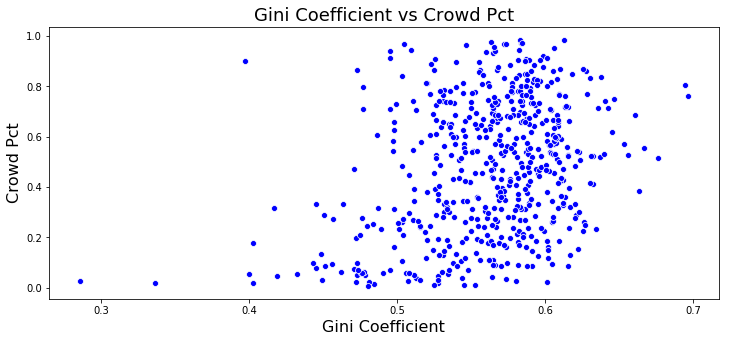

In [15]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=all_data['gini_coefficient'], y=all_data['crowd_pct'], color='blue')
plt.title('Gini Coefficient vs Crowd Pct', fontsize=18)
plt.xlabel('Gini Coefficient', fontsize=16)
plt.ylabel('Crowd Pct', fontsize=16)
#plt.ylim([0, 1])
#plt.xlim([0, 1])

Text(0, 0.5, 'Crowd Pct')

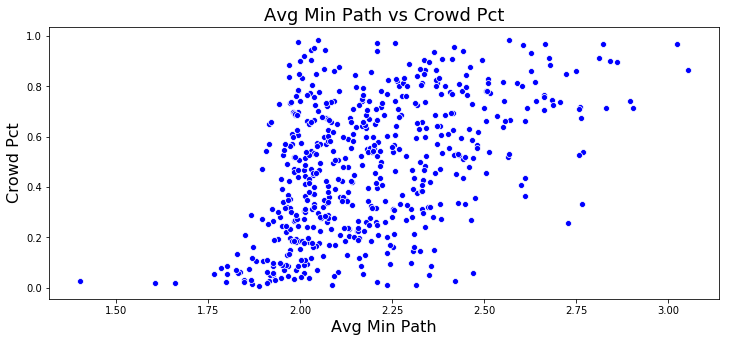

In [16]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=all_data['avg_min_path'], y=all_data['crowd_pct'], color='blue')
plt.title('Avg Min Path vs Crowd Pct', fontsize=18)
plt.xlabel('Avg Min Path', fontsize=16)
plt.ylabel('Crowd Pct', fontsize=16)
#plt.ylim([0, 1])
#plt.xlim([0, 1])

### Regression on Average Comments

Text(0, 0.5, 'Count')

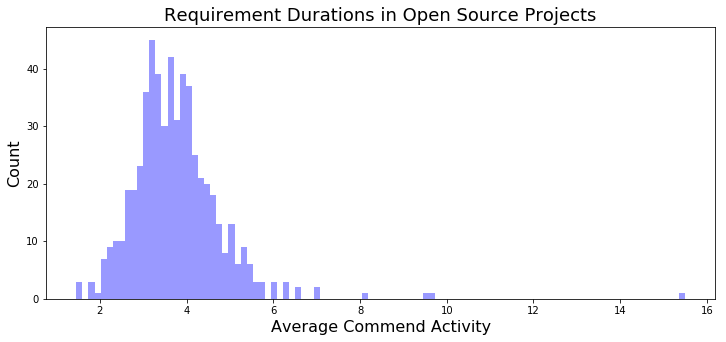

In [17]:
plt.figure(figsize=(12, 5))
sns.distplot(all_data['avg_comments'], kde=False, color='blue', bins=100)
plt.title('Requirement Durations in Open Source Projects', fontsize=18)
plt.xlabel('Average Commend Activity', fontsize=16)
plt.ylabel('Count', fontsize=16)

In [18]:
all_data['avg_comments'].describe()

count    562.000000
mean       3.766143
std        1.079171
min        1.457227
25%        3.148360
50%        3.629720
75%        4.223124
max       15.493750
Name: avg_comments, dtype: float64

In [19]:
y, X = dmatrices('avg_comments ~ ' + base_features,
                 data=all_data, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
yhat = res.predict(X)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           avg_comments   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     21.78
Date:                Sun, 15 Dec 2019   Prob (F-statistic):           2.32e-34
Time:                        20:52:52   Log-Likelihood:                -746.16
No. Observations:                 562   AIC:                             1514.
Df Residuals:                     551   BIC:                             1562.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [20]:
formula = """
avg_comments ~ crowd_pct + crowd_pct_2 + avg_clustering + 
    avg_min_path + gini_coefficient + avg_clusteringXcrowd_pct + 
    avg_min_pathXcrowd_pct + gini_coefficientXcrowd_pct + project_age + 
    topic_0 + topic_1 + topic_2 + topic_3 + topic_4 + topic_5 + 
    topic_6 + topic_7 + topic_8 + topic_9 + topic_10 + topic_11 + 
    topic_12 + topic_13 + topic_14 + topic_15 + topic_16 + topic_17 + 
    topic_18 + topic_19 + topic_20 + topic_21 + topic_22 + topic_23 + 
    topic_0:topic_1 + topic_0:topic_7 + topic_0:topic_9 + topic_0:topic_10 + 
    topic_0:topic_18 + topic_0:topic_19 + topic_0:topic_21 + 
    topic_1:topic_2 + topic_1:topic_9 + topic_1:topic_10 + topic_1:topic_13 + 
    topic_1:topic_14 + topic_1:topic_21 + topic_2:topic_11 + 
    topic_2:topic_12 + topic_2:topic_18 + topic_2:topic_20 + 
    topic_2:topic_22 + topic_3:topic_5 + topic_3:topic_11 + topic_3:topic_21 + 
    topic_4:topic_8 + topic_4:topic_18 + topic_5:topic_7 + topic_5:topic_9 + 
    topic_5:topic_11 + topic_5:topic_15 + topic_5:topic_17 + 
    topic_5:topic_22 + topic_6:topic_7 + topic_6:topic_8 + topic_6:topic_12 + 
    topic_6:topic_14 + topic_6:topic_16 + topic_6:topic_17 + 
    topic_6:topic_18 + topic_6:topic_19 + topic_7:topic_8 + topic_7:topic_16 + 
    topic_7:topic_23 + topic_8:topic_9 + topic_8:topic_15 + topic_9:topic_10 + 
    topic_9:topic_16 + topic_9:topic_19 + topic_9:topic_20 + 
    topic_9:topic_22 + topic_10:topic_12 + topic_10:topic_16 + 
    topic_10:topic_20 + topic_10:topic_22 + topic_10:topic_23 + 
    topic_11:topic_13 + topic_11:topic_14 + topic_11:topic_15 + 
    topic_11:topic_16 + topic_11:topic_17 + topic_11:topic_22 + 
    topic_14:topic_17 + topic_14:topic_20 + topic_14:topic_22 + 
    topic_15:topic_16 + topic_15:topic_18 + topic_15:topic_21 + 
    topic_16:topic_19 + topic_16:topic_22 + topic_17:topic_18 + 
    topic_17:topic_20 + topic_17:topic_22 + topic_18:topic_23 + 
    topic_19:topic_20 + topic_19:topic_21 + topic_19:topic_23 + 
    topic_20:topic_21 + topic_21:topic_22 + topic_3:topic_8 + 
    topic_7:topic_18 + topic_5:topic_12

"""
y, X = dmatrices(formula,
                 data=all_data, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           avg_comments   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.439
Method:                 Least Squares   F-statistic:                     4.953
Date:                Sun, 15 Dec 2019   Prob (F-statistic):           4.05e-34
Time:                        20:52:52   Log-Likelihood:                -615.46
No. Observations:                 562   AIC:                             1455.
Df Residuals:                     450   BIC:                             1940.
Df Model:                         111                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

(-2.0, 2.0)

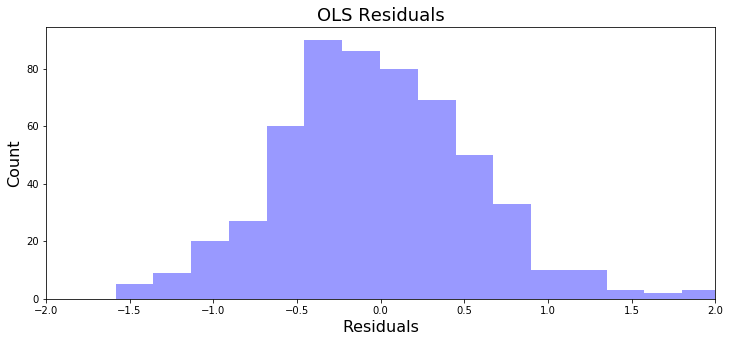

In [21]:
plt.figure(figsize=(12, 5))
sns.distplot(res.resid, kde=False, color='blue', bins=50)
plt.title('OLS Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([-2.0, 2.0])

(-2.0, 2.0)

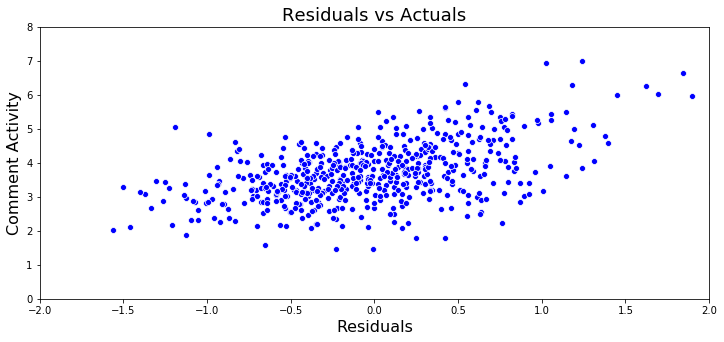

In [22]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=res.resid, y=all_data['avg_comments'], color='blue')
plt.title('Residuals vs Actuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Comment Activity', fontsize=16)
plt.ylim([0, 8])
plt.xlim([-2.0, 2.0])

In [23]:
mod = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.log))
res = mod.fit()
print(1 - (res.deviance/res.null_deviance))
print(len(res.params))
print(res.summary())

2019-12-15 20:52:54,151 [2103] WARNING  py.warnings: /home/matt/venv/phd/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  """Entry point for launching an IPython kernel.



0.6302980789014148
112
                 Generalized Linear Model Regression Results                  
Dep. Variable:           avg_comments   No. Observations:                  562
Model:                            GLM   Df Residuals:                      450
Model Family:                   Gamma   Df Model:                          111
Link Function:                    log   Scale:                        0.033179
Method:                          IRLS   Log-Likelihood:                -498.74
Date:                Sun, 15 Dec 2019   Deviance:                       14.036
Time:                        20:52:54   Pearson chi2:                     14.9
No. Iterations:                    17                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------

In [24]:
glm_marginal_effect('avg_clustering', res, X, all_data)

2.2218974387970105

In [25]:
glm_marginal_effect('avg_min_path', res, X, all_data)

-1.7476552461701473

In [26]:
glm_marginal_effect('gini_coefficient', res, X, all_data)

4.327791111230764

In [27]:
all_data['comment_prediction'] = res.predict(X)

(0, 1.5)

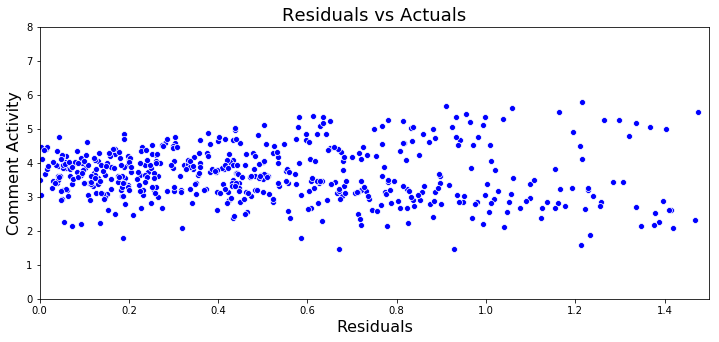

In [28]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=abs(yhat - all_data['avg_comments']), y=all_data['avg_comments'], color='blue')
plt.title('Residuals vs Actuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Comment Activity', fontsize=16)
plt.ylim([0, 8])
plt.xlim([0, 1.5])

In [29]:
avg_min_path = all_data['avg_min_path']
gini_coefficient = all_data['gini_coefficient']
avg_clustering = all_data['avg_clustering']
crowd_pct = all_data['crowd_pct']

effects_data = X.copy(deep=True)

effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*avg_clustering
effects_data['avg_min_pathXcrowd_pct'] = crowd_pct*avg_min_path
effects_data['gini_coefficientXcrowd_pct'] = crowd_pct*gini_coefficient

effects_data['crowd_pct'] = crowd_pct
effects_data['crowd_pct_2'] = crowd_pct**2

effects_data['predictions'] = res.predict(effects_data)
effects_data['crowd_pct_2_effect'] = effects_data['predictions'] * res.params['crowd_pct_2']
effects_data['crowd_pct_param'] = (res.params['crowd_pct']
                                    + avg_clustering * res.params['avg_clusteringXcrowd_pct']
                                    + avg_min_path * res.params['avg_min_pathXcrowd_pct']
                                    + avg_min_path * res.params['avg_min_pathXcrowd_pct'])
effects_data['total_effect'] = effects_data['predictions'] * (2 * res.params['crowd_pct_2'] * crowd_pct
                                                              + effects_data['crowd_pct_param'])
        
        
avg_effect = effects_data['total_effect'].mean()
print(avg_effect)

10.814040457018555


2019-12-15 20:52:59,195 [2103] WARNING  matplotlib.legend: No handles with labels found to put in legend.


Text(0.5, 0, 'Crowd Pct')

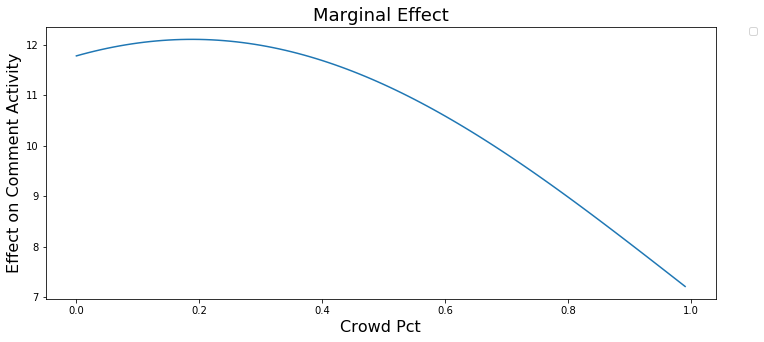

In [30]:
plt.figure(figsize=(12, 5))

marginal_effects = {'crowd_pct': [], 'effect': []}
avg_min_path = all_data['avg_min_path']
gini_coefficient = all_data['gini_coefficient']
avg_clustering = all_data['avg_clustering']


for i in range(100):
    effects_data = X.copy(deep=True)
    crowd_pct = i/100
    effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*avg_clustering
    effects_data['avg_min_pathXcrowd_pct'] = crowd_pct*avg_min_path
    effects_data['gini_coefficientXcrowd_pct'] = crowd_pct*gini_coefficient

    effects_data['crowd_pct'] = crowd_pct
    effects_data['crowd_pct_2'] = crowd_pct**2


    effects_data['predictions'] = res.predict(effects_data)
    effects_data['crowd_pct_2_effect'] = effects_data['predictions'] * res.params['crowd_pct_2']
    effects_data['crowd_pct_param'] = (res.params['crowd_pct']
                                        + avg_clustering * res.params['avg_clusteringXcrowd_pct']
                                        + avg_min_path * res.params['avg_min_pathXcrowd_pct']
                                        + avg_min_path * res.params['avg_min_pathXcrowd_pct'])
    effects_data['total_effect'] = effects_data['predictions'] * (2 * res.params['crowd_pct_2'] * crowd_pct
                                                                    + effects_data['crowd_pct_param'])
        
        
    avg_effect = effects_data['total_effect'].mean()
    marginal_effects['crowd_pct'].append(crowd_pct)
    marginal_effects['effect'].append(avg_effect)
        
marginal_effects = pd.DataFrame(marginal_effects)
sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'])

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect', fontsize=18)
plt.ylabel('Effect on Comment Activity', fontsize=16)
plt.xlabel('Crowd Pct', fontsize=16)

Text(0.5, 0, 'Marginal Effect')

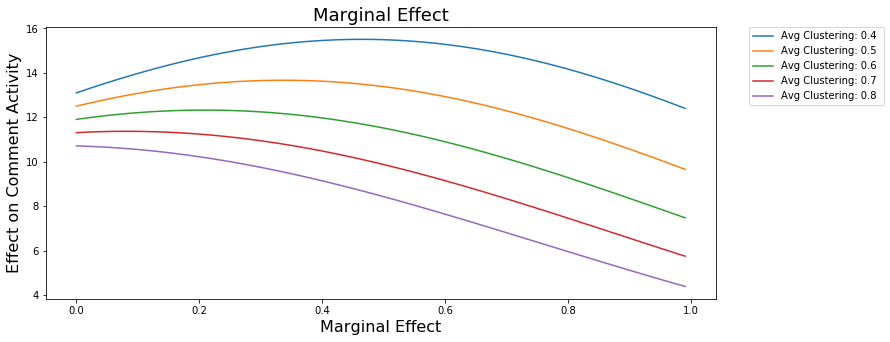

In [31]:
plt.figure(figsize=(12, 5))

for avg_clustering in [0.4, 0.5, 0.6, 0.7, 0.8]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Avg Clustering: {} '.format(avg_clustering)
    avg_min_path = all_data['avg_min_path']
    gini_coefficient = all_data['gini_coefficient']

    for i in range(100):
        effects_data = X.copy(deep=True)
        crowd_pct = i/100
        effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*avg_clustering
        effects_data['avg_min_pathXcrowd_pct'] = crowd_pct*avg_min_path
        effects_data['gini_coefficientXcrowd_pct'] = crowd_pct*gini_coefficient

        effects_data['crowd_pct'] = crowd_pct
        effects_data['crowd_pct_2'] = crowd_pct**2


        effects_data['predictions'] = res.predict(effects_data)
        effects_data['crowd_pct_2_effect'] = effects_data['predictions'] * res.params['crowd_pct_2']
        effects_data['crowd_pct_param'] = (res.params['crowd_pct']
                                           + avg_clustering * res.params['avg_clusteringXcrowd_pct']
                                           + avg_min_path * res.params['avg_min_pathXcrowd_pct']
                                           + avg_min_path * res.params['avg_min_pathXcrowd_pct'])
        effects_data['total_effect'] = effects_data['predictions'] * (2 * res.params['crowd_pct_2'] * crowd_pct
                                                                      + effects_data['crowd_pct_param'])
        
        
        avg_effect = effects_data['total_effect'].mean()
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect', fontsize=18)
plt.ylabel('Effect on Comment Activity', fontsize=16)
plt.xlabel('Marginal Effect', fontsize=16)

Text(0.5, 0, 'Marginal Effect')

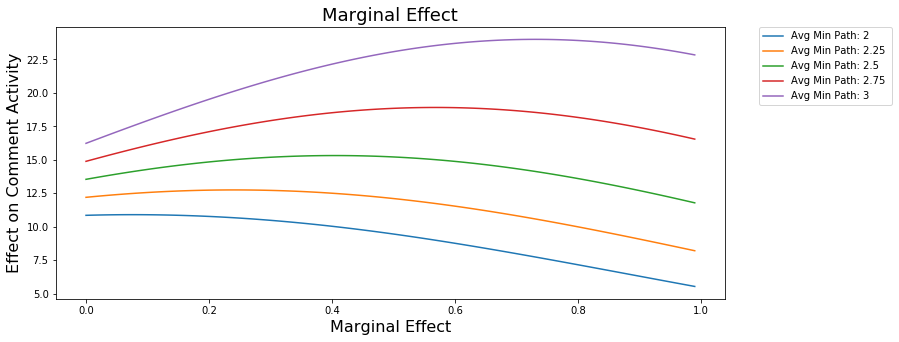

In [32]:
plt.figure(figsize=(12, 5))

for avg_min_path in [2, 2.25, 2.5, 2.75, 3]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Avg Min Path: {} '.format(avg_min_path)
    avg_clustering = all_data['avg_clustering']
    gini_coefficient = all_data['gini_coefficient']

    for i in range(100):
        effects_data = X.copy(deep=True)
        crowd_pct = i/100
        effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*avg_clustering
        effects_data['avg_min_pathXcrowd_pct'] = crowd_pct*avg_min_path
        effects_data['gini_coefficientXcrowd_pct'] = crowd_pct*gini_coefficient

        effects_data['crowd_pct'] = crowd_pct
        effects_data['crowd_pct_2'] = crowd_pct**2


        effects_data['predictions'] = res.predict(effects_data)
        effects_data['crowd_pct_2_effect'] = effects_data['predictions'] * res.params['crowd_pct_2']
        effects_data['crowd_pct_param'] = (res.params['crowd_pct']
                                           + avg_clustering * res.params['avg_clusteringXcrowd_pct']
                                           + avg_min_path * res.params['avg_min_pathXcrowd_pct']
                                           + avg_min_path * res.params['avg_min_pathXcrowd_pct'])
        effects_data['total_effect'] = effects_data['predictions'] * (2 * res.params['crowd_pct_2'] * crowd_pct
                                                                      + effects_data['crowd_pct_param'])
        
        
        avg_effect = effects_data['total_effect'].mean()
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect', fontsize=18)
plt.ylabel('Effect on Comment Activity', fontsize=16)
plt.xlabel('Marginal Effect', fontsize=16)

Text(0.5, 0, 'Marginal Effect')

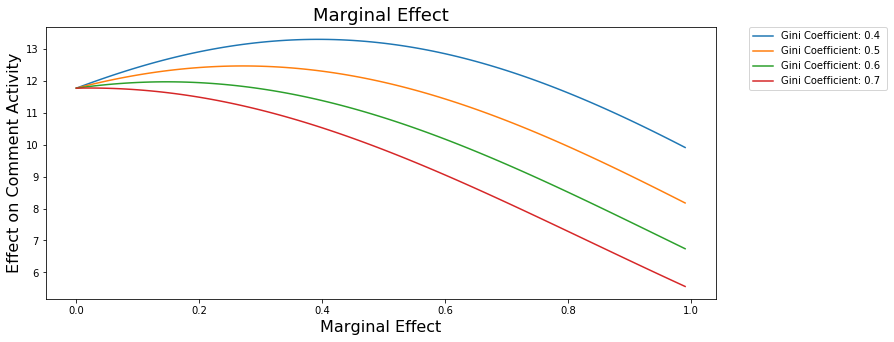

In [33]:
plt.figure(figsize=(12, 5))

for gini_coefficient in [0.4, 0.5, 0.6, 0.7]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Gini Coefficient: {} '.format(gini_coefficient)
    avg_clustering = all_data['avg_clustering']
    avg_min_path = all_data['avg_min_path']

    for i in range(100):
        effects_data = X.copy(deep=True)
        crowd_pct = i/100
        effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*avg_clustering
        effects_data['avg_min_pathXcrowd_pct'] = crowd_pct*avg_min_path
        effects_data['gini_coefficientXcrowd_pct'] = crowd_pct*gini_coefficient

        effects_data['crowd_pct'] = crowd_pct
        effects_data['crowd_pct_2'] = crowd_pct**2


        effects_data['predictions'] = res.predict(effects_data)
        effects_data['crowd_pct_2_effect'] = effects_data['predictions'] * res.params['crowd_pct_2']
        effects_data['crowd_pct_param'] = (res.params['crowd_pct']
                                           + avg_clustering * res.params['avg_clusteringXcrowd_pct']
                                           + avg_min_path * res.params['avg_min_pathXcrowd_pct']
                                           + avg_min_path * res.params['avg_min_pathXcrowd_pct'])
        effects_data['total_effect'] = effects_data['predictions'] * (2 * res.params['crowd_pct_2'] * crowd_pct
                                                                      + effects_data['crowd_pct_param'])
        
        
        avg_effect = effects_data['total_effect'].mean()
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect', fontsize=18)
plt.ylabel('Effect on Comment Activity', fontsize=16)
plt.xlabel('Marginal Effect', fontsize=16)

### Regression on Issues Submitted Over Time

Text(0, 0.5, 'Count')

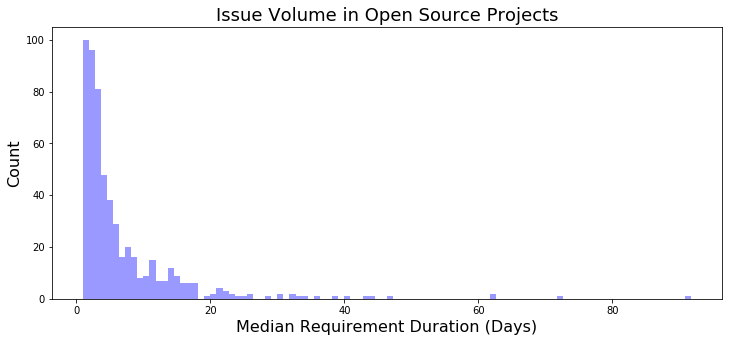

In [34]:
plt.figure(figsize=(12, 5))
sns.distplot(all_data['issues_over_time'], kde=False, color='blue', bins=100)
plt.title('Issue Volume in Open Source Projects', fontsize=18)
plt.xlabel('Median Requirement Duration (Days)', fontsize=16)
plt.ylabel('Count', fontsize=16)

In [35]:
all_data['issues_over_time'].describe()

count    562.000000
mean       6.773897
std        8.830984
min        0.914634
25%        2.195945
50%        3.726860
75%        7.739999
max       91.755319
Name: issues_over_time, dtype: float64

In [36]:
y, X = dmatrices('issues_over_time ~ ' + base_features,
                 data=all_data, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
yhat = res.predict(X)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:       issues_over_time   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                     46.44
Date:                Sun, 15 Dec 2019   Prob (F-statistic):           7.93e-67
Time:                        20:53:31   Log-Likelihood:                -1849.3
No. Observations:                 562   AIC:                             3721.
Df Residuals:                     551   BIC:                             3768.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [37]:
formula = """
issues_over_time ~ crowd_pct_2 + avg_clustering + 
    gini_coefficient + avg_clusteringXcrowd_pct + avg_min_pathXcrowd_pct + 
    gini_coefficientXcrowd_pct + total_contributors + project_age + 
    topic_0 + topic_1 + topic_2 + topic_3 + topic_4 + topic_5 + 
    topic_6 + topic_7 + topic_8 + topic_9 + topic_10 + topic_11 + 
    topic_12 + topic_13 + topic_14 + topic_15 + topic_16 + topic_17 + 
    topic_18 + topic_19 + topic_20 + topic_21 + topic_22 + topic_23 + 
    avg_min_path + topic_0:topic_1 + topic_0:topic_2 + topic_0:topic_3 + 
    topic_0:topic_5 + topic_0:topic_6 + topic_0:topic_7 + topic_0:topic_9 + 
    topic_0:topic_10 + topic_0:topic_11 + topic_0:topic_13 + 
    topic_0:topic_14 + topic_0:topic_15 + topic_0:topic_16 + 
    topic_0:topic_17 + topic_0:topic_18 + topic_0:topic_20 + 
    topic_0:topic_22 + topic_0:topic_23 + topic_1:topic_2 + topic_1:topic_4 + 
    topic_1:topic_5 + topic_1:topic_6 + topic_1:topic_10 + topic_1:topic_12 + 
    topic_1:topic_13 + topic_1:topic_14 + topic_1:topic_16 + 
    topic_1:topic_17 + topic_1:topic_18 + topic_1:topic_20 + 
    topic_2:topic_5 + topic_2:topic_16 + topic_2:topic_17 + topic_2:topic_19 + 
    topic_2:topic_22 + topic_2:topic_23 + topic_3:topic_7 + topic_3:topic_8 + 
    topic_3:topic_9 + topic_3:topic_11 + topic_3:topic_17 + topic_3:topic_18 + 
    topic_3:topic_22 + topic_4:topic_7 + topic_4:topic_10 + topic_4:topic_11 + 
    topic_4:topic_12 + topic_4:topic_14 + topic_4:topic_15 + 
    topic_4:topic_16 + topic_4:topic_18 + topic_4:topic_22 + 
    topic_4:topic_23 + topic_5:topic_6 + topic_5:topic_8 + topic_5:topic_11 + 
    topic_5:topic_14 + topic_5:topic_16 + topic_5:topic_17 + 
    topic_5:topic_18 + topic_6:topic_8 + topic_6:topic_10 + topic_6:topic_11 + 
    topic_6:topic_12 + topic_6:topic_14 + topic_6:topic_16 + 
    topic_6:topic_17 + topic_6:topic_18 + topic_6:topic_21 + 
    topic_6:topic_22 + topic_7:topic_9 + topic_7:topic_10 + topic_7:topic_11 + 
    topic_7:topic_17 + topic_7:topic_19 + topic_7:topic_20 + 
    topic_7:topic_22 + topic_8:topic_9 + topic_8:topic_10 + topic_8:topic_14 + 
    topic_8:topic_15 + topic_8:topic_17 + topic_8:topic_19 + 
    topic_8:topic_21 + topic_8:topic_22 + topic_9:topic_13 + 
    topic_9:topic_16 + topic_9:topic_18 + topic_9:topic_19 + 
    topic_9:topic_21 + topic_9:topic_22 + topic_9:topic_23 + 
    topic_10:topic_12 + topic_10:topic_15 + topic_10:topic_17 + 
    topic_10:topic_18 + topic_10:topic_19 + topic_10:topic_21 + 
    topic_10:topic_22 + topic_11:topic_13 + topic_11:topic_14 + 
    topic_11:topic_16 + topic_11:topic_17 + topic_11:topic_21 + 
    topic_11:topic_23 + topic_12:topic_13 + topic_12:topic_15 + 
    topic_12:topic_19 + topic_12:topic_22 + topic_12:topic_23 + 
    topic_13:topic_16 + topic_13:topic_17 + topic_13:topic_18 + 
    topic_13:topic_19 + topic_13:topic_20 + topic_14:topic_16 + 
    topic_14:topic_17 + topic_14:topic_20 + topic_14:topic_23 + 
    topic_15:topic_16 + topic_15:topic_17 + topic_15:topic_18 + 
    topic_15:topic_20 + topic_15:topic_21 + topic_16:topic_17 + 
    topic_16:topic_22 + topic_16:topic_23 + topic_17:topic_19 + 
    topic_17:topic_20 + topic_17:topic_21 + topic_17:topic_23 + 
    topic_18:topic_19 + topic_18:topic_20 + topic_18:topic_22 + 
    topic_18:topic_23 + topic_19:topic_23 + topic_20:topic_21 + 
    topic_20:topic_23 + topic_21:topic_22 + topic_22:topic_23
"""
y, X = dmatrices(formula,
                 data=all_data, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:       issues_over_time   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     12.76
Date:                Sun, 15 Dec 2019   Prob (F-statistic):           2.33e-93
Time:                        20:53:31   Log-Likelihood:                -1487.1
No. Observations:                 562   AIC:                             3322.
Df Residuals:                     388   BIC:                             4076.
Df Model:                         173                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

Text(0, 0.5, 'Count')

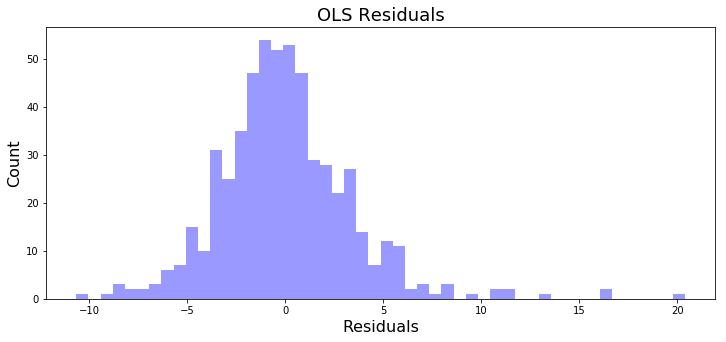

In [38]:
plt.figure(figsize=(12, 5))
sns.distplot(res.resid, kde=False, color='blue', bins=50)
plt.title('OLS Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Count', fontsize=16)

Text(0, 0.5, 'Issues over Time')

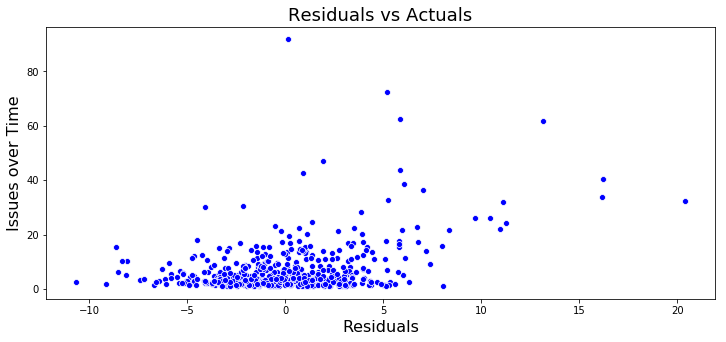

In [39]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=res.resid, y=all_data['issues_over_time'], color='blue')
plt.title('Residuals vs Actuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Issues over Time', fontsize=16)
#plt.ylim([0, 2.5])
#plt.xlim([-0.75, .75])

In [40]:
mod = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.log))
res = mod.fit()
print(1 - (res.deviance/res.null_deviance))
print(len(res.params))
print(res.summary())

2019-12-15 20:53:33,127 [2103] WARNING  py.warnings: /home/matt/venv/phd/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  """Entry point for launching an IPython kernel.



0.8134756623211163
174
                 Generalized Linear Model Regression Results                  
Dep. Variable:       issues_over_time   No. Observations:                  562
Model:                            GLM   Df Residuals:                      388
Model Family:                   Gamma   Df Model:                          173
Link Function:                    log   Scale:                         0.25514
Method:                          IRLS   Log-Likelihood:                -1151.1
Date:                Sun, 15 Dec 2019   Deviance:                       95.135
Time:                        20:53:34   Pearson chi2:                     99.0
No. Iterations:                    53                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------

In [41]:
glm_marginal_effect('avg_clustering', res, X, all_data)

-0.22384668560166132

In [42]:
glm_marginal_effect('avg_min_path', res, X, all_data)

-1.2219450634648306

In [43]:
glm_marginal_effect('gini_coefficient', res, X, all_data)

15.22719217625398

In [44]:
avg_clustering = all_data['avg_clustering']
avg_min_path = all_data['avg_min_path']
crowd_pct = all_data['crowd_pct']


effects_data = X.copy(deep=True)

effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*avg_clustering
effects_data['avg_min_pathXcrowd_pct'] = crowd_pct*avg_min_path
effects_data['gini_coefficientXcrowd_pct'] = crowd_pct*gini_coefficient

effects_data['crowd_pct_2'] = crowd_pct**2

effects_data['predictions'] = res.predict(effects_data)
effects_data['crowd_pct_2_effect'] = effects_data['predictions'] * res.params['crowd_pct_2']
effects_data['crowd_pct_param'] = (avg_clustering * res.params['avg_clusteringXcrowd_pct']
                                    + avg_min_path * res.params['avg_min_pathXcrowd_pct']
                                    + avg_min_path * res.params['avg_min_pathXcrowd_pct'])
effects_data['total_effect'] = effects_data['predictions'] * (2 * res.params['crowd_pct_2'] * crowd_pct
                                                              + effects_data['crowd_pct_param'])
        
        
avg_effect = effects_data['total_effect'].mean()
print(avg_effect)

-20.759904585863314


2019-12-15 20:53:37,189 [2103] WARNING  matplotlib.legend: No handles with labels found to put in legend.


Text(0.5, 0, 'Crowd Pct')

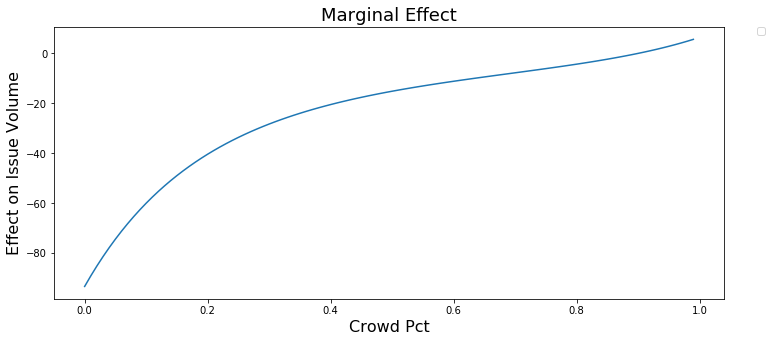

In [45]:
plt.figure(figsize=(12, 5))

marginal_effects = {'crowd_pct': [], 'effect': []}
avg_min_path = all_data['avg_min_path']
gini_coefficient = all_data['gini_coefficient']
avg_clustering = all_data['avg_clustering']


for i in range(100):
    effects_data = X.copy(deep=True)
    crowd_pct = i/100
    effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*avg_clustering
    effects_data['avg_min_pathXcrowd_pct'] = crowd_pct*avg_min_path
    effects_data['gini_coefficientXcrowd_pct'] = crowd_pct*gini_coefficient

    effects_data['crowd_pct_2'] = crowd_pct**2

    effects_data['predictions'] = res.predict(effects_data)
    effects_data['crowd_pct_2_effect'] = effects_data['predictions'] * res.params['crowd_pct_2']
    effects_data['crowd_pct_param'] = (avg_clustering * res.params['avg_clusteringXcrowd_pct']
                                        + avg_min_path * res.params['avg_min_pathXcrowd_pct']
                                        + avg_min_path * res.params['avg_min_pathXcrowd_pct'])
    effects_data['total_effect'] = effects_data['predictions'] * (2 * res.params['crowd_pct_2'] * crowd_pct
                                                                    + effects_data['crowd_pct_param'])
        
        
    avg_effect = effects_data['total_effect'].mean()
    marginal_effects['crowd_pct'].append(crowd_pct)
    marginal_effects['effect'].append(avg_effect)
        
marginal_effects = pd.DataFrame(marginal_effects)
sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'])

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect', fontsize=18)
plt.ylabel('Effect on Issue Volume', fontsize=16)
plt.xlabel('Crowd Pct', fontsize=16)

Text(0.5, 0, 'Marginal Effect')

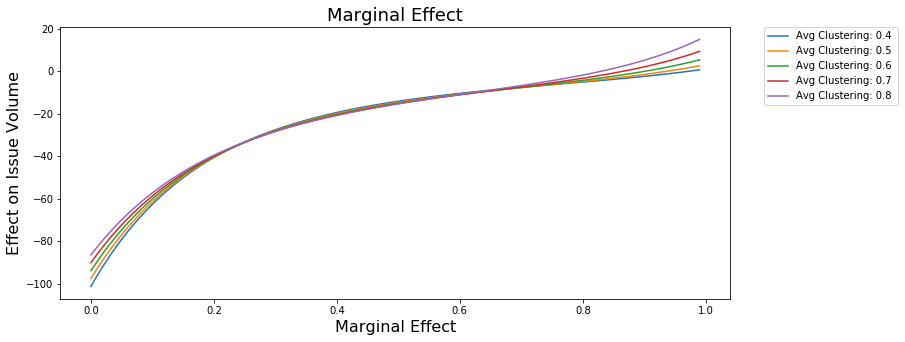

In [46]:
plt.figure(figsize=(12, 5))

for avg_clustering in [0.4, 0.5, 0.6, 0.7, 0.8]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Avg Clustering: {} '.format(avg_clustering)
    avg_min_path = all_data['avg_min_path']
    gini_coefficient = all_data['gini_coefficient']

    for i in range(100):
        effects_data = X.copy(deep=True)
        crowd_pct = i/100
        effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*avg_clustering
        effects_data['avg_min_pathXcrowd_pct'] = crowd_pct*avg_min_path
        effects_data['gini_coefficientXcrowd_pct'] = crowd_pct*gini_coefficient

        effects_data['crowd_pct_2'] = crowd_pct**2

        effects_data['predictions'] = res.predict(effects_data)
        effects_data['crowd_pct_2_effect'] = effects_data['predictions'] * res.params['crowd_pct_2']
        effects_data['crowd_pct_param'] = (avg_clustering * res.params['avg_clusteringXcrowd_pct']
                                           + avg_min_path * res.params['avg_min_pathXcrowd_pct']
                                           + avg_min_path * res.params['avg_min_pathXcrowd_pct'])
        effects_data['total_effect'] = effects_data['predictions'] * (2 * res.params['crowd_pct_2'] * crowd_pct
                                                                      + effects_data['crowd_pct_param'])
        
        
        avg_effect = effects_data['total_effect'].mean()
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect', fontsize=18)
plt.ylabel('Effect on Issue Volume', fontsize=16)
plt.xlabel('Marginal Effect', fontsize=16)

Text(0.5, 0, 'Marginal Effect')

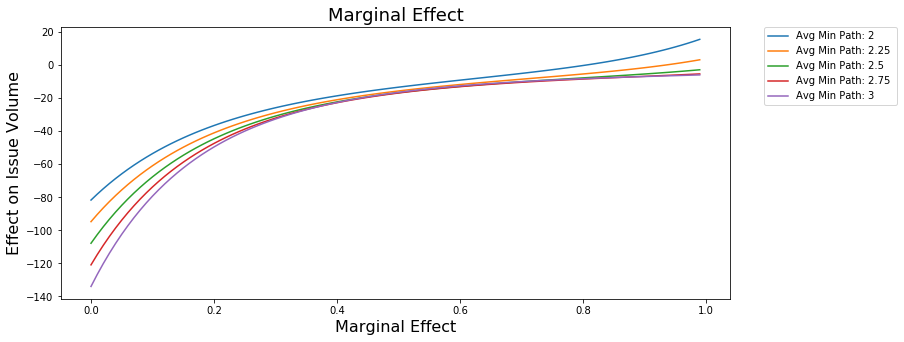

In [47]:
plt.figure(figsize=(12, 5))

for avg_min_path in [2, 2.25, 2.5, 2.75, 3]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Avg Min Path: {} '.format(avg_min_path)
    avg_clustering = all_data['avg_clustering']
    gini_coefficient = all_data['gini_coefficient']

    for i in range(100):
        effects_data = X.copy(deep=True)
        crowd_pct = i/100
        effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*avg_clustering
        effects_data['avg_min_pathXcrowd_pct'] = crowd_pct*avg_min_path
        effects_data['gini_coefficientXcrowd_pct'] = crowd_pct*gini_coefficient

        effects_data['crowd_pct_2'] = crowd_pct**2

        effects_data['predictions'] = res.predict(effects_data)
        effects_data['crowd_pct_2_effect'] = effects_data['predictions'] * res.params['crowd_pct_2']
        effects_data['crowd_pct_param'] = (avg_clustering * res.params['avg_clusteringXcrowd_pct']
                                           + avg_min_path * res.params['avg_min_pathXcrowd_pct']
                                           + avg_min_path * res.params['avg_min_pathXcrowd_pct'])
        effects_data['total_effect'] = effects_data['predictions'] * (2 * res.params['crowd_pct_2'] * crowd_pct
                                                                      + effects_data['crowd_pct_param'])
        
        
        avg_effect = effects_data['total_effect'].mean()
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect', fontsize=18)
plt.ylabel('Effect on Issue Volume', fontsize=16)
plt.xlabel('Marginal Effect', fontsize=16)

Text(0.5, 0, 'Marginal Effect')

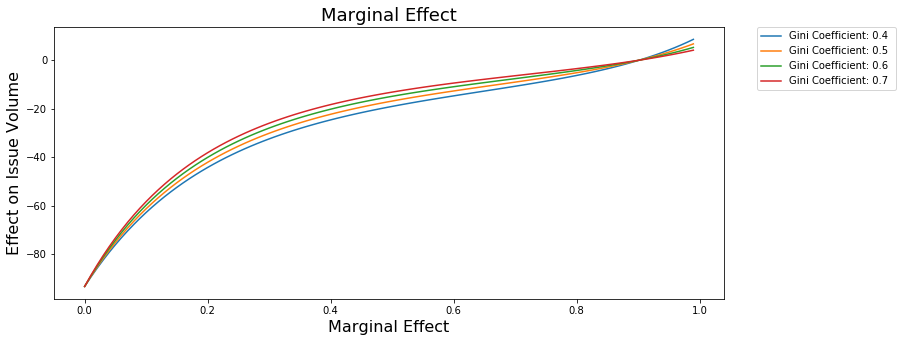

In [48]:
plt.figure(figsize=(12, 5))

for gini_coefficient in [0.4, 0.5, 0.6, 0.7]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Gini Coefficient: {} '.format(gini_coefficient)
    avg_clustering = all_data['avg_clustering']
    avg_min_path = all_data['avg_min_path']

    for i in range(100):
        effects_data = X.copy(deep=True)
        crowd_pct = i/100
        effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*avg_clustering
        effects_data['avg_min_pathXcrowd_pct'] = crowd_pct*avg_min_path
        effects_data['gini_coefficientXcrowd_pct'] = crowd_pct*gini_coefficient

        effects_data['crowd_pct_2'] = crowd_pct**2

        effects_data['predictions'] = res.predict(effects_data)
        effects_data['crowd_pct_2_effect'] = effects_data['predictions'] * res.params['crowd_pct_2']
        effects_data['crowd_pct_param'] = (avg_clustering * res.params['avg_clusteringXcrowd_pct']
                                           + avg_min_path * res.params['avg_min_pathXcrowd_pct']
                                           + avg_min_path * res.params['avg_min_pathXcrowd_pct'])
        effects_data['total_effect'] = effects_data['predictions'] * (2 * res.params['crowd_pct_2'] * crowd_pct
                                                                      + effects_data['crowd_pct_param'])
        
        
        avg_effect = effects_data['total_effect'].mean()
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect', fontsize=18)
plt.ylabel('Effect on Issue Volume', fontsize=16)
plt.xlabel('Marginal Effect', fontsize=16)

### Pct Closed out under 30

(0, 1)

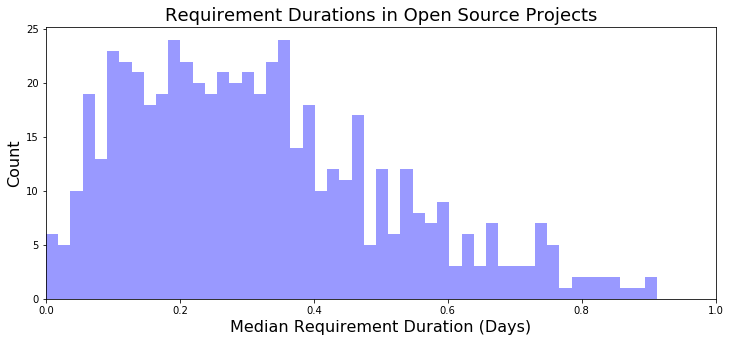

In [49]:
plt.figure(figsize=(12, 5))
sns.distplot(all_data['pct_under_30'], kde=False, color='blue', bins=50)
plt.title('Requirement Durations in Open Source Projects', fontsize=18)
plt.xlabel('Median Requirement Duration (Days)', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([0,1])

In [50]:
all_data['pct_under_30'].describe()

count    562.000000
mean       0.319167
std        0.195067
min        0.000000
25%        0.166806
50%        0.288506
75%        0.435968
max        0.912752
Name: pct_under_30, dtype: float64

In [51]:
y, X = dmatrices('pct_under_30 ~ ' + base_features,
                 data=all_data, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
yhat = res.predict(X)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           pct_under_30   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     15.14
Date:                Sun, 15 Dec 2019   Prob (F-statistic):           5.01e-24
Time:                        20:54:06   Log-Likelihood:                 189.83
No. Observations:                 562   AIC:                            -357.7
Df Residuals:                     551   BIC:                            -310.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [52]:
formula = """
 pct_under_30 ~ crowd_pct_2 + avg_clustering + gini_coefficient + 
    avg_min_pathXcrowd_pct + project_age + topic_0 + topic_1 + 
    topic_2 + topic_3 + topic_4 + topic_5 + topic_6 + topic_7 + 
    topic_8 + topic_9 + topic_10 + topic_11 + topic_12 + topic_13 + 
    topic_14 + topic_15 + topic_16 + topic_17 + topic_18 + topic_19 + 
    topic_20 + topic_21 + topic_22 + topic_23 + topic_0:topic_6 + 
    topic_0:topic_7 + topic_0:topic_8 + topic_0:topic_18 + topic_0:topic_20 + 
    topic_0:topic_22 + topic_0:topic_23 + topic_1:topic_10 + 
    topic_1:topic_11 + topic_1:topic_13 + topic_1:topic_14 + 
    topic_1:topic_17 + topic_1:topic_20 + topic_1:topic_22 + 
    topic_2:topic_4 + topic_2:topic_10 + topic_2:topic_16 + topic_2:topic_17 + 
    topic_2:topic_18 + topic_2:topic_22 + topic_3:topic_4 + topic_3:topic_9 + 
    topic_3:topic_10 + topic_3:topic_13 + topic_3:topic_15 + 
    topic_3:topic_16 + topic_3:topic_21 + topic_3:topic_22 + 
    topic_4:topic_6 + topic_4:topic_9 + topic_4:topic_10 + topic_4:topic_12 + 
    topic_4:topic_14 + topic_4:topic_19 + topic_4:topic_23 + 
    topic_5:topic_6 + topic_5:topic_9 + topic_5:topic_15 + topic_5:topic_18 + 
    topic_5:topic_19 + topic_5:topic_23 + topic_6:topic_10 + 
    topic_6:topic_17 + topic_6:topic_22 + topic_7:topic_8 + topic_7:topic_9 + 
    topic_7:topic_10 + topic_7:topic_12 + topic_7:topic_14 + 
    topic_7:topic_15 + topic_7:topic_16 + topic_7:topic_20 + 
    topic_8:topic_9 + topic_8:topic_12 + topic_8:topic_14 + topic_8:topic_17 + 
    topic_8:topic_18 + topic_9:topic_13 + topic_9:topic_15 + 
    topic_9:topic_17 + topic_9:topic_19 + topic_9:topic_22 + 
    topic_9:topic_23 + topic_10:topic_15 + topic_10:topic_16 + 
    topic_10:topic_18 + topic_10:topic_19 + topic_10:topic_21 + 
    topic_11:topic_15 + topic_11:topic_17 + topic_12:topic_18 + 
    topic_12:topic_19 + topic_12:topic_20 + topic_13:topic_14 + 
    topic_13:topic_16 + topic_13:topic_19 + topic_13:topic_22 + 
    topic_13:topic_23 + topic_14:topic_18 + topic_14:topic_19 + 
    topic_14:topic_22 + topic_15:topic_20 + topic_15:topic_21 + 
    topic_15:topic_23 + topic_16:topic_18 + topic_16:topic_23 + 
    topic_17:topic_19 + topic_17:topic_23 + topic_18:topic_21 + 
    topic_18:topic_22 + topic_18:topic_23 + topic_19:topic_20 + 
    topic_20:topic_22 + topic_21:topic_23 + topic_2:topic_19 + 
    topic_0:topic_10 + topic_1:topic_3
"""
y, X = dmatrices(formula,
                 data=all_data, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           pct_under_30   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.465
Method:                 Least Squares   F-statistic:                     4.866
Date:                Sun, 15 Dec 2019   Prob (F-statistic):           3.90e-35
Time:                        20:54:07   Log-Likelihood:                 368.70
No. Observations:                 562   AIC:                            -483.4
Df Residuals:                     435   BIC:                             66.70
Df Model:                         126                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0

Text(0, 0.5, 'Count')

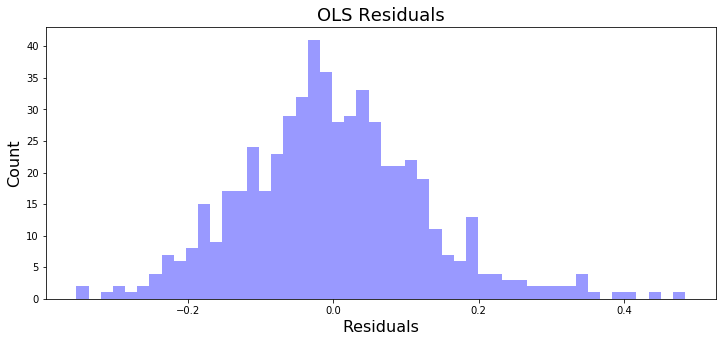

In [53]:
plt.figure(figsize=(12, 5))
sns.distplot(res.resid, kde=False, color='blue', bins=50)
plt.title('OLS Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Count', fontsize=16)

(-0.2, 0.2)

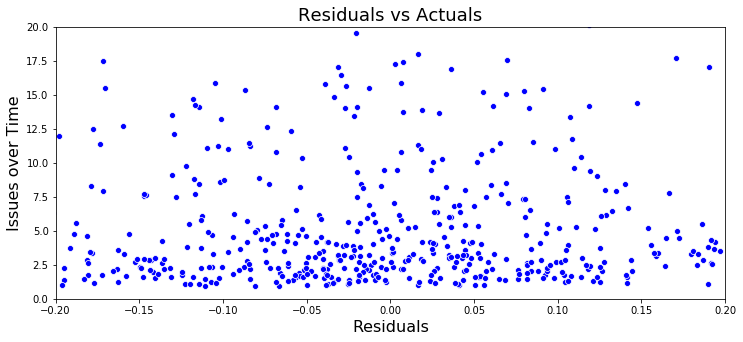

In [54]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=res.resid, y=all_data['issues_over_time'], color='blue')
plt.title('Residuals vs Actuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Issues over Time', fontsize=16)
plt.ylim([0, 20])
plt.xlim([-0.2, 0.2])

In [55]:
params = {'crowd_pct_2': 1.45256931291647,
          'avg_min_pathXcrowd_pct': -1.0979488383932,
          'avg_clustering': -1.94602300853525,
          'gini_coefficient': 1.99828032440915}

In [56]:
for x in params:
    print('{}: {}'.format(x, np.exp(params[x])))

gini_coefficient: 7.3763602390268606
avg_clustering: 0.14284102098406498
crowd_pct_2: 4.274081873611587
avg_min_pathXcrowd_pct: 0.33355455680224094


In [57]:
np.exp(np.mean(all_data['crowd_pct']*params['avg_min_pathXcrowd_pct']))

0.5898038581443397

In [58]:
plt.figure(figsize=(12, 5))

marginal_effects = {'crowd_pct': [], 'effect': []}
avg_min_path = all_data['avg_min_path']
crowd_pct = all_data['crowd_pct']

effects_data = X.copy(deep=True)

effects_data['avg_min_pathXcrowd_pct'] = crowd_pct*avg_min_path
effects_data['crowd_pct_2'] = crowd_pct**2
        
effects_data['crowd_pct_param'] = avg_min_path * res.params['avg_min_pathXcrowd_pct']
effects_data['total_effect'] = np.exp(2 * params['crowd_pct_2'] * crowd_pct
                                      + effects_data['crowd_pct_param'])
        
        
avg_effect = effects_data['total_effect'].mean()
print(avg_effect)

3.427356659333102


<Figure size 864x360 with 0 Axes>

2019-12-15 20:54:09,733 [2103] WARNING  matplotlib.legend: No handles with labels found to put in legend.


Text(0.5, 0, 'Marginal Effect')

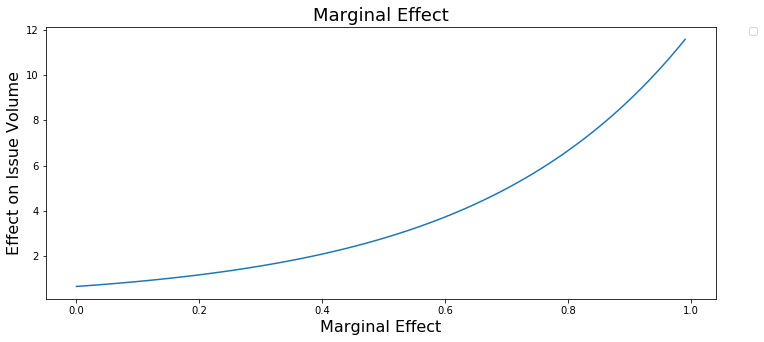

In [59]:
plt.figure(figsize=(12, 5))

marginal_effects = {'crowd_pct': [], 'effect': []}
avg_min_path = all_data['avg_min_path']

for i in range(100):
    effects_data = X.copy(deep=True)
    crowd_pct = i/100
    effects_data['avg_min_pathXcrowd_pct'] = crowd_pct*avg_min_path
    effects_data['crowd_pct_2'] = crowd_pct**2
        
    effects_data['crowd_pct_param'] = avg_min_path * res.params['avg_min_pathXcrowd_pct']
    effects_data['total_effect'] = np.exp(2 * params['crowd_pct_2'] * crowd_pct
                                            + effects_data['crowd_pct_param'])
        
        
    avg_effect = effects_data['total_effect'].mean()
    marginal_effects['crowd_pct'].append(crowd_pct)
    marginal_effects['effect'].append(avg_effect)
        
marginal_effects = pd.DataFrame(marginal_effects)
sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'])

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect', fontsize=18)
plt.ylabel('Effect on Issue Volume', fontsize=16)
plt.xlabel('Marginal Effect', fontsize=16)

Text(0.5, 0, 'Marginal Effect')

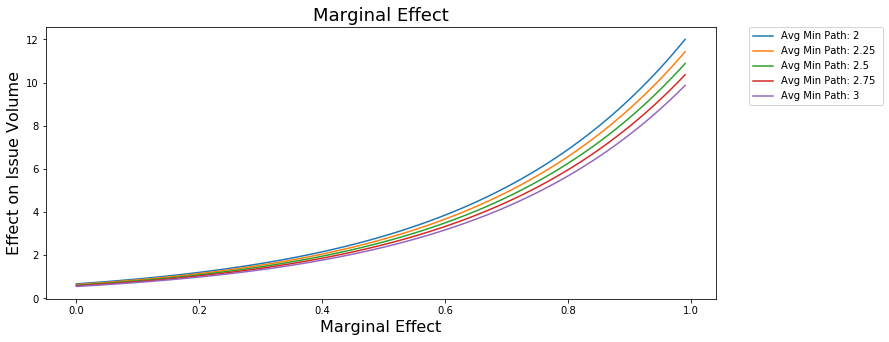

In [60]:
plt.figure(figsize=(12, 5))

for avg_min_path in [2, 2.25, 2.5, 2.75, 3]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Avg Min Path: {} '.format(avg_min_path)

    for i in range(100):
        effects_data = X.copy(deep=True)
        crowd_pct = i/100
        effects_data['avg_min_pathXcrowd_pct'] = crowd_pct*avg_min_path
        effects_data['crowd_pct_2'] = crowd_pct**2
        
        effects_data['crowd_pct_param'] = avg_min_path * res.params['avg_min_pathXcrowd_pct']
        effects_data['total_effect'] = np.exp(2 * params['crowd_pct_2'] * crowd_pct
                                              + effects_data['crowd_pct_param'])
        
        
        avg_effect = effects_data['total_effect'].mean()
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect', fontsize=18)
plt.ylabel('Effect on Issue Volume', fontsize=16)
plt.xlabel('Marginal Effect', fontsize=16)

### Avg First Comment Time

In [61]:
all_data['avg_first_comment'].describe()

count    562.000000
mean      29.004449
std       37.018716
min        0.169014
25%        8.695482
50%       18.767917
75%       35.140768
max      389.746114
Name: avg_first_comment, dtype: float64

Text(0, 0.5, 'Count')

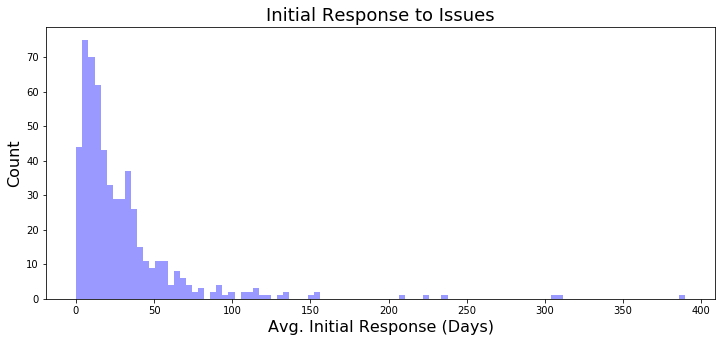

In [62]:
plt.figure(figsize=(12, 5))
sns.distplot(all_data['avg_first_comment'], kde=False, color='blue', bins=100)
plt.title('Initial Response to Issues', fontsize=18)
plt.xlabel('Avg. Initial Response (Days)', fontsize=16)
plt.ylabel('Count', fontsize=16)
#plt.xlim([0,1])

In [63]:
y, X = dmatrices('avg_first_comment ~ ' + base_features,
                 data=all_data, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
yhat = res.predict(X)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:      avg_first_comment   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     24.79
Date:                Sun, 15 Dec 2019   Prob (F-statistic):           8.43e-39
Time:                        20:54:15   Log-Likelihood:                -2722.2
No. Observations:                 562   AIC:                             5466.
Df Residuals:                     551   BIC:                             5514.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [64]:
formula = """
avg_first_comment ~ crowd_pct + crowd_pct_2 + avg_clustering + 
    avg_min_path + gini_coefficient + avg_clusteringXcrowd_pct + 
    total_contributors + project_age + topic_0 + topic_1 + topic_2 + 
    topic_3 + topic_4 + topic_5 + topic_6 + topic_7 + topic_8 + 
    topic_9 + topic_10 + topic_11 + topic_12 + topic_13 + topic_14 + 
    topic_15 + topic_16 + topic_17 + topic_18 + topic_19 + topic_20 + 
    topic_21 + topic_22 + topic_23 + topic_0:topic_5 + topic_0:topic_11 + 
    topic_0:topic_12 + topic_0:topic_13 + topic_0:topic_15 + 
    topic_0:topic_21 + topic_1:topic_3 + topic_1:topic_4 + topic_1:topic_7 + 
    topic_1:topic_8 + topic_1:topic_11 + topic_1:topic_12 + topic_1:topic_17 + 
    topic_1:topic_19 + topic_1:topic_21 + topic_1:topic_22 + 
    topic_2:topic_6 + topic_2:topic_7 + topic_2:topic_12 + topic_2:topic_13 + 
    topic_2:topic_14 + topic_2:topic_15 + topic_2:topic_18 + 
    topic_2:topic_20 + topic_2:topic_22 + topic_3:topic_6 + topic_3:topic_11 + 
    topic_3:topic_13 + topic_3:topic_14 + topic_3:topic_15 + 
    topic_3:topic_16 + topic_3:topic_19 + topic_3:topic_21 + 
    topic_3:topic_22 + topic_4:topic_5 + topic_4:topic_7 + topic_4:topic_8 + 
    topic_4:topic_9 + topic_4:topic_12 + topic_4:topic_14 + topic_4:topic_18 + 
    topic_4:topic_22 + topic_5:topic_11 + topic_5:topic_12 + 
    topic_5:topic_22 + topic_6:topic_7 + topic_6:topic_9 + topic_6:topic_13 + 
    topic_6:topic_17 + topic_6:topic_18 + topic_6:topic_19 + 
    topic_6:topic_21 + topic_6:topic_22 + topic_7:topic_9 + topic_7:topic_12 + 
    topic_7:topic_22 + topic_8:topic_11 + topic_8:topic_12 + 
    topic_8:topic_13 + topic_8:topic_14 + topic_8:topic_15 + 
    topic_8:topic_18 + topic_8:topic_21 + topic_9:topic_12 + 
    topic_9:topic_14 + topic_9:topic_18 + topic_9:topic_20 + 
    topic_9:topic_21 + topic_9:topic_22 + topic_10:topic_12 + 
    topic_10:topic_20 + topic_10:topic_21 + topic_11:topic_14 + 
    topic_11:topic_15 + topic_11:topic_17 + topic_11:topic_19 + 
    topic_11:topic_20 + topic_11:topic_22 + topic_12:topic_14 + 
    topic_12:topic_17 + topic_12:topic_19 + topic_12:topic_20 + 
    topic_12:topic_21 + topic_13:topic_15 + topic_13:topic_18 + 
    topic_13:topic_19 + topic_14:topic_15 + topic_14:topic_16 + 
    topic_14:topic_18 + topic_14:topic_20 + topic_14:topic_21 + 
    topic_15:topic_16 + topic_15:topic_17 + topic_15:topic_20 + 
    topic_16:topic_19 + topic_17:topic_18 + topic_17:topic_22 + 
    topic_18:topic_22 + topic_18:topic_23 + topic_19:topic_20 + 
    topic_21:topic_23 + topic_0:topic_1 + topic_1:topic_10 + 
    topic_9:topic_19
"""
y, X = dmatrices(formula,
                 data=all_data, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
print(len(res.params))
print(res.summary())

137
                            OLS Regression Results                            
Dep. Variable:      avg_first_comment   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     4.896
Date:                Sun, 15 Dec 2019   Prob (F-statistic):           2.19e-36
Time:                        20:54:16   Log-Likelihood:                -2561.7
No. Observations:                 562   AIC:                             5397.
Df Residuals:                     425   BIC:                             5991.
Df Model:                         136                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept           

Text(0, 0.5, 'Count')

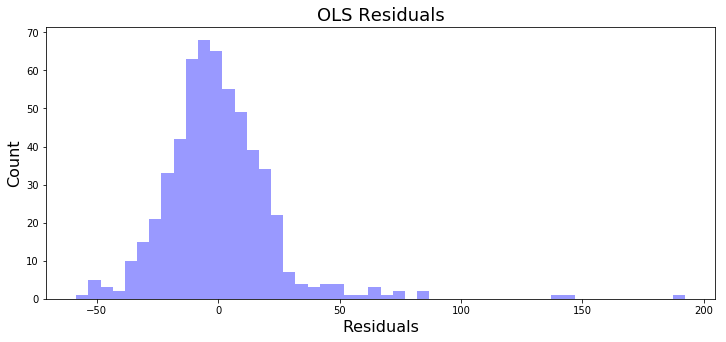

In [65]:
plt.figure(figsize=(12, 5))
sns.distplot(res.resid, kde=False, color='blue', bins=50)
plt.title('OLS Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Count', fontsize=16)

Text(0, 0.5, 'Issues over Time')

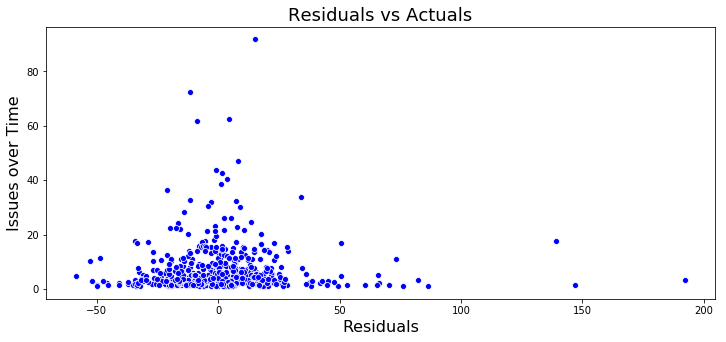

In [66]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=res.resid, y=all_data['issues_over_time'], color='blue')
plt.title('Residuals vs Actuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Issues over Time', fontsize=16)
#plt.ylim([0, 20])
#plt.xlim([-0.2, 0.2])

In [67]:
mod = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.log))
res = mod.fit()
print(1 - (res.deviance/res.null_deviance))
print(len(res.params))
print(res.summary())

2019-12-15 20:54:17,171 [2103] WARNING  py.warnings: /home/matt/venv/phd/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  """Entry point for launching an IPython kernel.



0.6313948956679314
137
                 Generalized Linear Model Regression Results                  
Dep. Variable:      avg_first_comment   No. Observations:                  562
Model:                            GLM   Df Residuals:                      425
Model Family:                   Gamma   Df Model:                          136
Link Function:                    log   Scale:                         0.45434
Method:                          IRLS   Log-Likelihood:                -2151.9
Date:                Sun, 15 Dec 2019   Deviance:                       220.88
Time:                        20:54:17   Pearson chi2:                     193.
No. Iterations:                    46                                         
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
I

In [68]:
glm_marginal_effect('avg_clustering', res, X, all_data)

41.038922912426

In [69]:
glm_marginal_effect('avg_min_path', res, X, all_data)

35.66776453541375

In [70]:
glm_marginal_effect('gini_coefficient', res, X, all_data)

-147.9928320168797

In [71]:
marginal_effects = {'crowd_pct': [], 'effect': []}
avg_clustering = all_data['avg_clustering']
crowd_pct = all_data['crowd_pct']

effects_data = X.copy(deep=True)
effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*avg_clustering


effects_data['crowd_pct'] = crowd_pct
effects_data['crowd_pct_2'] = crowd_pct**2


effects_data['predictions'] = res.predict(effects_data)
effects_data['crowd_pct_2_effect'] = effects_data['predictions'] * res.params['crowd_pct_2']
effects_data['crowd_pct_param'] = (res.params['crowd_pct']
                                    + avg_clustering * res.params['avg_clusteringXcrowd_pct'])
effects_data['total_effect'] = effects_data['predictions'] * (2 * res.params['crowd_pct_2'] * crowd_pct
                                                                + effects_data['crowd_pct_param'])
        
        
avg_effect = effects_data['total_effect'].mean()
print(avg_effect)

3.4050581193926592


2019-12-15 20:54:20,527 [2103] WARNING  matplotlib.legend: No handles with labels found to put in legend.


Text(0.5, 0, 'Crowd Pct')

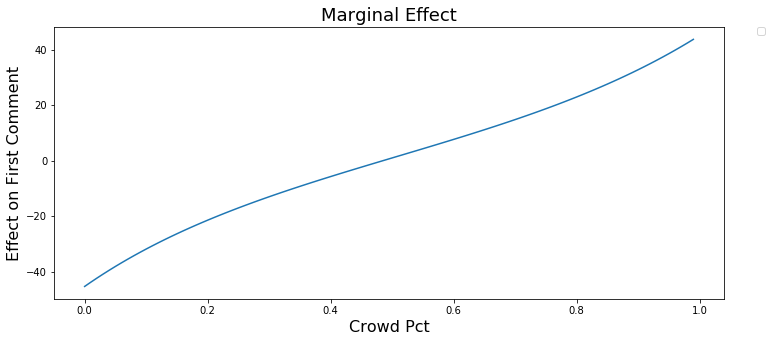

In [72]:
plt.figure(figsize=(12, 5))

marginal_effects = {'crowd_pct': [], 'effect': []}
avg_clustering = all_data['avg_clustering']


for i in range(100):
    effects_data = X.copy(deep=True)
    crowd_pct = i/100
    effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*avg_clustering


    effects_data['crowd_pct'] = crowd_pct
    effects_data['crowd_pct_2'] = crowd_pct**2


    effects_data['predictions'] = res.predict(effects_data)
    effects_data['crowd_pct_2_effect'] = effects_data['predictions'] * res.params['crowd_pct_2']
    effects_data['crowd_pct_param'] = (res.params['crowd_pct']
                                        + avg_clustering * res.params['avg_clusteringXcrowd_pct'])
    effects_data['total_effect'] = effects_data['predictions'] * (2 * res.params['crowd_pct_2'] * crowd_pct
                                                                    + effects_data['crowd_pct_param'])
        
        
    avg_effect = effects_data['total_effect'].mean()
    marginal_effects['crowd_pct'].append(crowd_pct)
    marginal_effects['effect'].append(avg_effect)
        
marginal_effects = pd.DataFrame(marginal_effects)
sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'])

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect', fontsize=18)
plt.ylabel('Effect on First Comment', fontsize=16)
plt.xlabel('Crowd Pct', fontsize=16)

Text(0.5, 0, 'Marginal Effect')

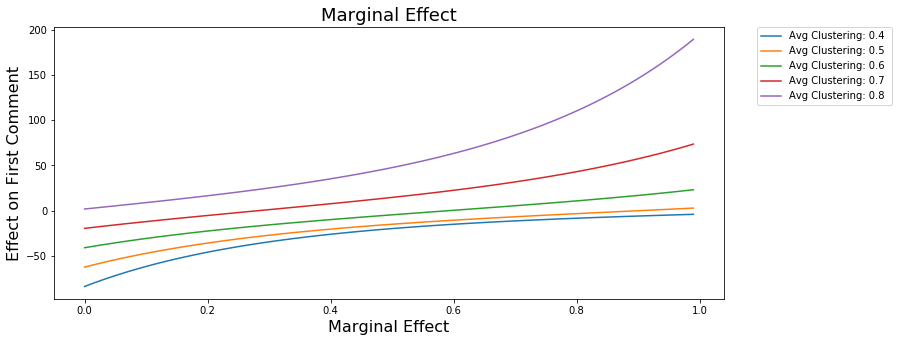

In [73]:
plt.figure(figsize=(12, 5))

for avg_clustering in [0.4, 0.5, 0.6, 0.7, 0.8]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Avg Clustering: {} '.format(avg_clustering)

    for i in range(100):
        effects_data = X.copy(deep=True)
        crowd_pct = i/100
        effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*avg_clustering

        effects_data['crowd_pct'] = crowd_pct
        effects_data['crowd_pct_2'] = crowd_pct**2


        effects_data['predictions'] = res.predict(effects_data)
        effects_data['crowd_pct_2_effect'] = effects_data['predictions'] * res.params['crowd_pct_2']
        effects_data['crowd_pct_param'] = (res.params['crowd_pct']
                                           + avg_clustering * res.params['avg_clusteringXcrowd_pct'])
        effects_data['total_effect'] = effects_data['predictions'] * (2 * res.params['crowd_pct_2'] * crowd_pct
                                                                      + effects_data['crowd_pct_param'])
        
        
        avg_effect = effects_data['total_effect'].mean()
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect', fontsize=18)
plt.ylabel('Effect on First Comment', fontsize=16)
plt.xlabel('Marginal Effect', fontsize=16)